In [1]:
from devito import *
from AI4Advection_Diffusion import AI4Advection, PDE_Solver
from examples.cfd import  plot_field
from filter.filter_generator import upwind
import numpy as np
import torch
import matplotlib.pyplot as plt

torch.Size([1, 1, 512, 512])


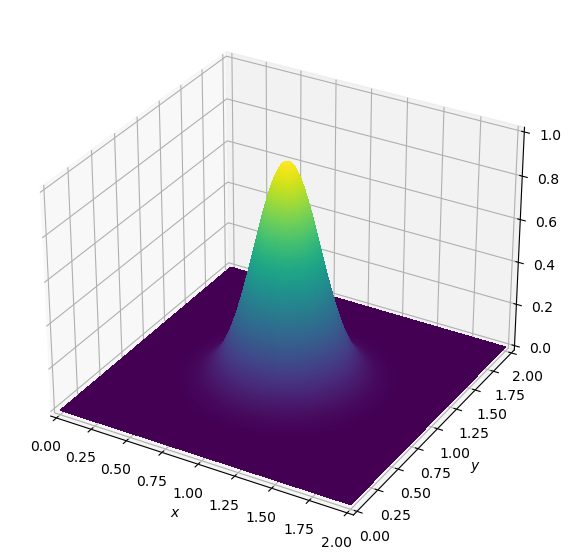

In [2]:

def init_smooth(field, dx, dy):
    nx, ny = field.shape
    x = np.linspace(0, (nx-1)*dx, nx)
    y = np.linspace(0, (ny-1)*dy, ny)
    X, Y = np.meshgrid(x, y, indexing='ij')
    
    # 使用高斯分布初始化平滑场
    sigma = 0.2
    field[:] = np.exp(-((X-nx*dx/2)**2 + (Y-ny*dy/2)**2) / (2*sigma**2))
def init_square_wave(field, dx, dy):
    nx, ny = field.shape
    x = np.linspace(0, (nx-1)*dx, nx)
    y = np.linspace(0, (ny-1)*dy, ny)
    X, Y = np.meshgrid(x, y, indexing='ij')
    
    # 初始化为零或其他背景值
    field[:] = 0.0
    
    # 方波的尺寸和位置
    center_x, center_y = nx*dx/2, ny*dy/2
    width, height = 0.2 * nx * dx, 0.2 * ny * dy
    
    # 设置方波的区域
    field[(X >= center_x - width/2) & (X <= center_x + width/2) &
          (Y >= center_y - height/2) & (Y <= center_y + height/2)] = 1.0
    
nt = 100  # Number of timesteps
dt = 0.0001  # Timestep size (sigma=0.2)
nx = 512
ny = 512
length = 2.


# Then we create a grid and our function
grid = Grid(shape=(nx, ny), extent=(length, length))
u = TimeFunction(name='u', grid=grid,save = nt,time_order = 2, space_order = 2)

init_smooth(field=u.data[0], dx=grid.spacing[0], dy=grid.spacing[1])
#init_square_wave(field=u.data[0], dx=grid.spacing[0], dy=grid.spacing[1])
u_tensor_init_ad = torch.tensor(u.data[0], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
torch.save(u_tensor_init_ad[0,0,:,:].detach(),f'./pure_advection/AD0.pt')
print(u_tensor_init_ad.shape)
plot_field(u.data[0])


In [3]:
c = 2
eq = Eq(u.dt + c*u.dx + c*u.dy)
eq

Eq(2*Derivative(u(time, x, y), x) + 2*Derivative(u(time, x, y), y) + Derivative(u(time, x, y), time), 0)

In [4]:

for i in range(1,nt):
    model_adv = PDE_Solver(eq = eq,u = u, dx = length/nx, dy = length/ny, nx = nx, ny = ny,dt = dt, solver = upwind,omega=1)
    result = model_adv.forward(4)

    u.data[0] = result.detach().numpy()
    torch.save(result[0,0,:,:].detach(),f'./pure_advection/AD{i}.pt')

In [5]:

model_adv.A

tensor([[[[ 0.0000, -0.0512,  0.0000],
          [-0.0512,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000]]]])

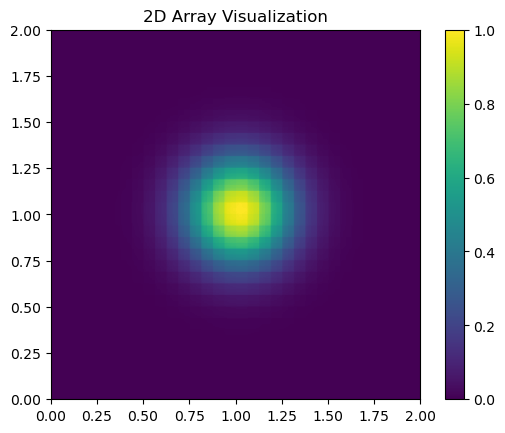

In [6]:
import matplotlib.pyplot as plt
test = torch.load('./pure_advection/AD4.pt')

plt.imshow(test.numpy(), extent=(0, 2, 0, 2), origin='lower', cmap='viridis')
plt.colorbar()  
plt.title("2D Array Visualization")
plt.show()

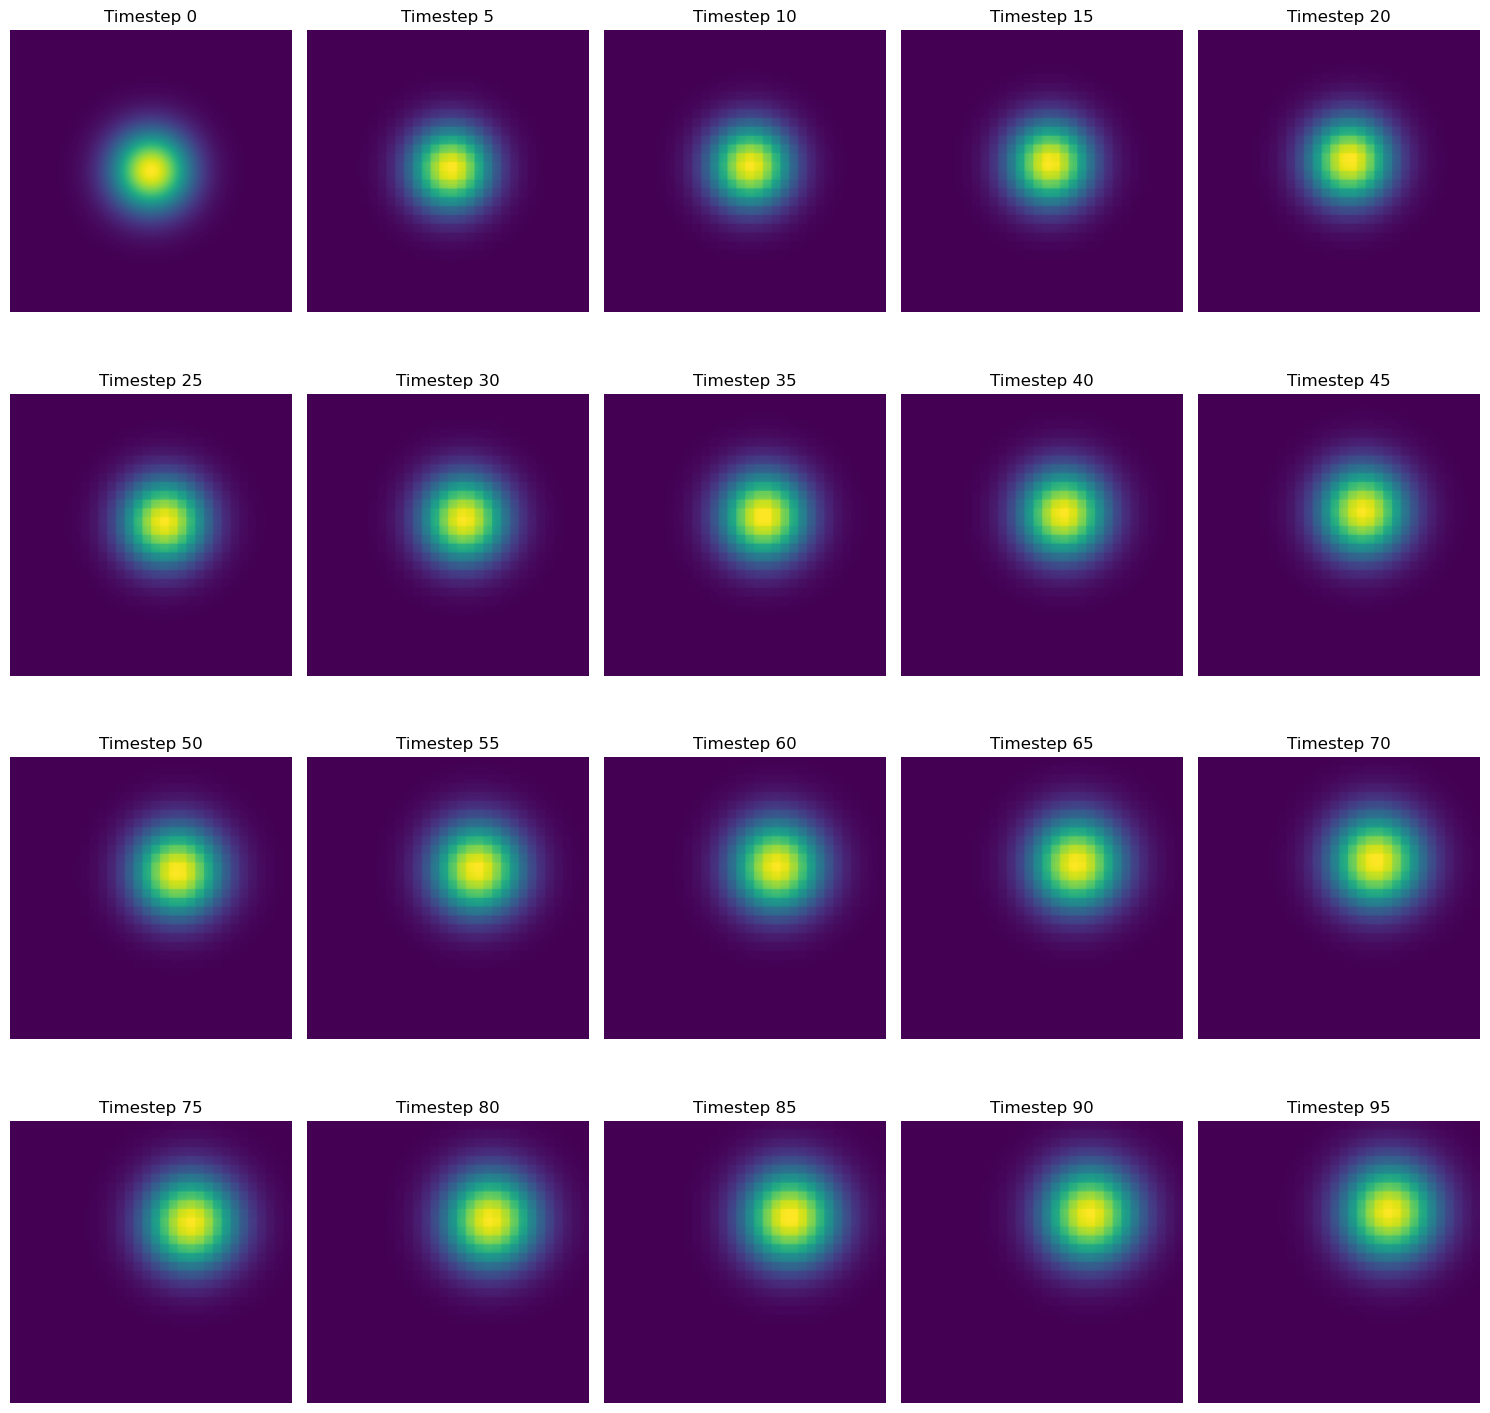

In [7]:
tensors = []
for i in range(0, nt, 5):
    tensor = torch.load(f'./pure_advection/AD{i}.pt')
    tensors.append(tensor)

fig, axes = plt.subplots(nrows=len(tensors)//5, ncols=5, figsize=(15, 15))

for idx, tensor in enumerate(tensors):
    ax = axes[idx // 5, idx % 5]
    data = tensor.detach().numpy()
    ax.imshow(data, cmap='viridis', origin='lower')
    ax.set_title(f'Timestep {idx*5}')
    ax.axis('off')  

plt.tight_layout()
plt.show()